In [1]:
# Name: example_basic
# Authors: Stephan Meighen-Berger, Kruteesh Desai
# A basic example how to use the package

In [2]:
# imports
from constants import pdm_constants as const
from config import config
from pone_aeff import Aeff
from dm2nu import DM2Nu
from atm_shower import Atm_Shower
from detectors import Detector
import numpy as np
import matplotlib.pyplot as plt
from limit_calc import Limits
from bkgrd_calc import Background
from signal_calc import Signal
from pdm import PDM
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2
from scipy.stats import *
from pone_aeff import Aeff
import pickle

In [3]:
# picture path
PICS = '../pics/'
name=[r'$\nu_{\mu}$', r"$\nu_e$", r"$\nu_{\tau}$"]  # ,r'$\nu_{e}$',r'$\nu_{\tau}$'
# Plotting standards
std_size = 6.  # Size of the plot
fontsize = 15.  # Fontsize in the plot
lw=0.5  # Linewidth
h_length=0.5  # Handle length for the legends
export_dpi = 500  # Dpi for the image export

In [32]:
# Some example settings
#config['atmospheric showers']['interaction model'] = 'SIBYLL2.3c'
#config['atmospheric showers']['theta angles'] = np.linspace(0., 90., 91)
#config['atmospheric showers']['particles of interest']=['nue']
config['general']['detector'] = 'combined'


In [33]:
pdm = PDM()

Loading Effective Area


100%|██████████| 1/1 [00:00<00:00, 55.36it/s]

combined
121
121


In [34]:
e_grid = pdm._shower_sim.egrid
#eff_po_1 = pdm._aeff.spl_A15(pdm._shower_sim.egrid)
eff_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/27_11/data/eff_area_ice.pkl','rb'))

In [35]:
#back_po = pickle.load(open('../data/background_pone_sm.pkl','rb'))
background_ic = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/22_03_desk/data/background_ice.pkl','rb'))
back_comb =  pickle.load(open('/home/kruteesh/Desktop/dm_data_server/14_03/data/background_combined.pkl','rb'))
#background_pone_sm = pickle.load(open('../data/background_pone_sm.pkl','rb'))

In [36]:
np.array(background_ic["numu"]).shape

(9, 121)

In [37]:
signal_comb = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/24_03_desk/limits_signal_IceCube.pkl','rb'))

In [38]:
# Grids
mass_grid = config['simulation parameters']['mass grid']
sv_grid = config['simulation parameters']['sv grid']
mass_id = 1

sv_id = -1

mass_grid[mass_id], sv_grid[sv_id]
# The limit calculation


(316.22776601683796, 1e-21)

In [39]:
dphi_2=np.loadtxt(open("../data/m_1e2.csv"), delimiter = ",")
dphi_2[dphi_2[:,0].sort()]

dphi_4=np.loadtxt(open("../data/m_1e4.csv"), delimiter = ",")
dphi_4[dphi_4[:,0].sort()]

dphi_6=np.loadtxt(open("../data/m_1e6.csv"), delimiter = ",")
dphi_6[dphi_6[:,0].sort()]
dphi_ice=np.loadtxt(open("../data/icecube.csv"), delimiter = ",")
dphi_ice[dphi_ice[:,0].sort()]

array([[[2.12522998e+02, 1.63541848e-04],
        [3.75355026e+02, 1.17293567e-04],
        [6.29536175e+02, 4.82400307e-05],
        [1.29846584e+03, 2.68117327e-05],
        [2.54321174e+03, 1.27334869e-05],
        [5.08126850e+03, 5.00379406e-06],
        [1.02741133e+04, 1.64695632e-06],
        [2.01231674e+04, 6.33333228e-07],
        [4.15055504e+04, 3.04185979e-07],
        [8.12939394e+04, 1.45312927e-07],
        [1.64454709e+05, 5.65882534e-08],
        [2.78806881e+05, 4.47804058e-08],
        [4.21663736e+05, 3.16824398e-08],
        [7.56379773e+05, 2.36346234e-08],
        [1.97223492e+06, 1.29547786e-08]]])

In [40]:
dphi_4=UnivariateSpline(dphi_4[:,0],dphi_4[:,1],k=1,s=0,ext=1)
#mass_grid[0],sv_grid[-1],mass_grid[-1],sv_grid[-1]
dphi_ic=UnivariateSpline(dphi_ice[:,0],dphi_ice[:,1],k=1,s=0,ext=1)
dphi_6=UnivariateSpline(dphi_6[:,0],dphi_6[:,1],k=1,s=0, ext=1)
dphi_2=UnivariateSpline(dphi_2[:,0],dphi_2[:,1],k=1,s=0, ext=1)


In [41]:
shower_flux = pickle.load(open('../data/shower.p','rb'))
shower_po = shower_flux[2][45]['numu']
surface_fluxe_ice = pickle.load(open("../data/surf_store_v1.p", "rb"))
shower_ice = surface_fluxe_ice[20][3] # background fluxes at 20° ----

In [42]:
c= const()

In [43]:
J = c.J_d1 + c.J_p1 + c.J_s1
sv = 0.5e-22


/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:280: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:279: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:279: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:280: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd


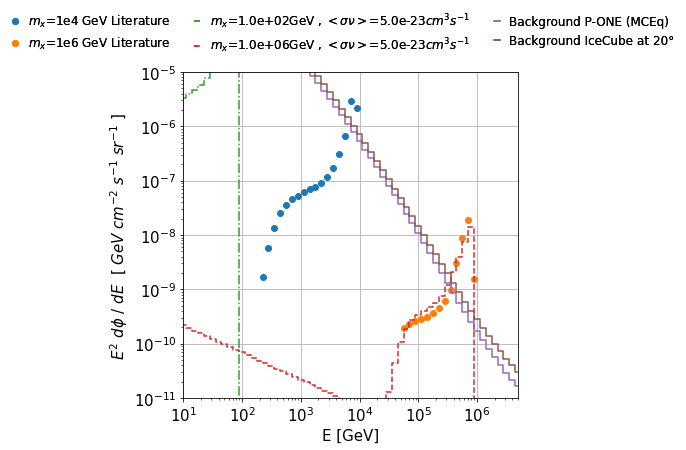

In [44]:
figure, ax1 = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True) 

ax1.step(pdm._shower_sim._egrid, dphi_4(pdm._shower_sim._egrid),'o', label=r'$m_{x}$=1e4 GeV Literature')
ax1.step(pdm._shower_sim._egrid, dphi_6(pdm._shower_sim._egrid), 'o',label=r'$m_{x}$=1e6 GeV Literature')

ax1.step(pdm._shower_sim.egrid, (pdm._dm_nu.extra_galactic_flux(pdm._shower_sim.egrid,mass_grid[0],sv)) * pdm._shower_sim.egrid**2.,'-.',
         label=r'$m_{x}$=%.1eGeV , $<\sigma\nu>$=%.1e$cm^{3}s^{-1}$'%(mass_grid[0],sv))
ax1.step(pdm._shower_sim.egrid, (pdm._dm_nu.extra_galactic_flux(pdm._shower_sim.egrid,mass_grid[-1],sv))* pdm._shower_sim.egrid**2.,'--',
         label=r'$m_{x}$=%.1eGeV , $<\sigma\nu>$=%.1e$cm^{3}s^{-1}$'%(mass_grid[-1],sv))
ax1.step(pdm._shower_sim.egrid, shower_po*pdm._shower_sim.egrid**2, label='Background P-ONE (MCEq)') # Karlsruhe Corsika
ax1.step(pdm._shower_sim.egrid, shower_ice*pdm._shower_sim.egrid**2, label='Background IceCube at 20°')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel('E [GeV]', fontsize=fontsize)
ax1.set_ylabel(r'$E^2$ $d\phi$ / $dE$  [ $GeV$ $cm^{-2}$ $s^{-1}$ $sr^{-1}$ ]', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize)
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize)
ax1.set_xlim(1e1, 0.5e7)
ax1.set_ylim(1e-11,1e-5)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(1.5, +1.12),
                 ncol=3, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.grid()
# ---------------------------------------------
# Showing the image
plt.show()

In [45]:
pdm._signal_data

{'numu': array([[[9.28851271e-01, 5.78548709e-01, 3.95713740e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.02578382e-01, 5.08393855e-01, 3.54514844e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.21699201e-01, 6.80164431e-01, 4.52463373e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.52937369e-02, 1.71991661e-02, 1.84804862e-02, ...,
          1.50869204e-19, 8.65561940e-20, 4.94300830e-20],
         [2.25402089e-03, 2.52345148e-03, 2.73953739e-03, ...,
          2.18096036e-21, 1.25134059e-21, 7.14780814e-22],
         [2.85378548e-04, 3.19444004e-04, 3.44608797e-04, ...,
          1.19494365e-21, 6.85774044e-22, 3.91821348e-22]],
 
        [[3.91693333e+00, 2.43971968e+00, 1.66871101e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.38444497e+00, 2.14387911e+00, 1.49497670e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],

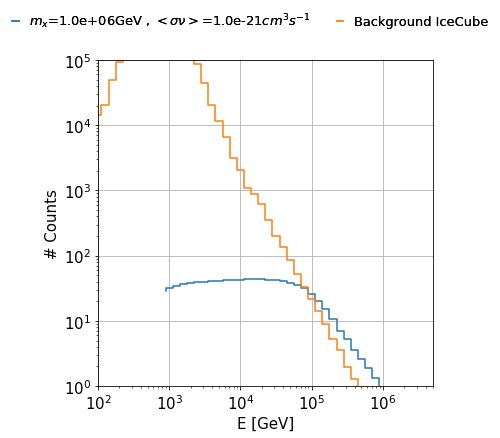

In [46]:
figure, ax1 = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True) 

#ax1.step(pdm._shower_sim.egrid[-len(pdm._signal_data[-1][-1]):],
#signal_comb[-1][0],'-',
#         label=r'$m_{x}$=%.1eGeV , $<\sigma\nu>$=%.1e$cm^{3}s^{-1}$'%(mass_grid[4],sv_grid[0]))
ax1.step(pdm._shower_sim.egrid[-len(pdm._signal_data['numu'][-1][-1]):], pdm._signal_data['numu'][-1][-1],'-',
         label=r'$m_{x}$=%.1eGeV , $<\sigma\nu>$=%.1e$cm^{3}s^{-1}$'%(mass_grid[-1],sv_grid[-1]))

#ax1.step(pdm._shower_sim._egrid, background_pone_sm['numu'],'-', label='Background P-ONE un-Smeared')
#ax1.step(pdm._shower_sim._egrid, back_comb['numu'],'-', label='Background combined')

ax1.step(pdm._shower_sim._egrid, np.sum(background_ic['numu'],axis=0),'-', label='Background IceCube')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel('E [GeV]', fontsize=fontsize)
ax1.set_ylabel(r'# Counts', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize)
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize)
ax1.set_xlim(1e2, 0.5e7)
ax1.set_ylim(1e0,1e5)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(1.2, +1.12),
                 ncol=2, fontsize=fontsize-2, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.grid()
# ---------------------------------------------
# Showing the image
plt.show()

In [47]:
ratio = pdm._dm_nu.extra_galactic_flux(pdm._shower_sim.egrid, mass_grid[mass_id], sv_grid[sv_id]) / (shower_po) 

/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:279: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:280: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd


In [48]:
aa =[[1,1,1]]
bbb= [[2,2,2]]
aa+bbb

[[1, 1, 1], [2, 2, 2]]

In [49]:
np.add(aa,bbb)

array([[3, 3, 3]])

In [50]:
flux={}
flux[15]={}
flux[85]={}
flux[120]={}
flux[15]['numu'] = (dphi_4(pdm._shower_sim.egrid)) * pdm._shower_sim._egrid**(-2)
flux[85]['numu'] = flux[15]['numu']
flux[120]['numu'] = flux[15]['numu']
flux[15]['nue']=flux[85]['nue']=flux[120]['nue']=flux[15]['nutau']=flux[85]['nutau']=flux[120]['nutau']=flux[15]['numu']
#_lit=pdm._Detector.sim2dec(flux,True)["numu"]


In [51]:
signal_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/limits_signal_IceCube.pkl','rb'))


In [52]:
# Loading comparison data
th_cl = np.loadtxt(open("../data/thermal_relic.csv"), delimiter = ",")
unitarity = np.loadtxt(open('../data/Unitarity_bound.csv'), delimiter = ',')
cl_lit = np.loadtxt('../data/CL_PONE.csv', delimiter=",")
cl_lit = (cl_lit[cl_lit[:, 0].argsort()])
unitarity = (unitarity[unitarity[:, 0].argsort()])

limits_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/24_03_desk/limits_results_IceCube.pkl','rb'))
limits_pone_unsm = pickle.load(open("../data/25_03/unsmeared/limits_results_POne_unsm.pkl","rb"))
limits_com = pickle.load(open("/home/kruteesh/Desktop/dm_data_server/14_03/data/limits_results.pkl", "rb"))
cl_lit_ice = np.loadtxt('/home/kruteesh/Desktop/DM_nu_simulation_P-One/Literature/limits_Ice.csv', delimiter=",")
cl_lit_ice = (cl_lit_ice[cl_lit_ice[:, 0].argsort()])
xx,yy = np.meshgrid(np.log10( np.logspace(1, 6, 20)),np.log10( np.logspace(1, 6, 20)))

In [53]:
#signal_count_sim = pdm._signal.signal_calc(pdm._shower_sim.egrid,mass_grid[mass_id],sv_grid[sv_id])

In [54]:
#ratio_c = (signal_count_sim["numu"] /       
#            pdm._limit_calc._bkgrd['numu'])

In [55]:
#ratio_c

In [56]:
#plt.title('scaling correction'+str(config['advanced']['scaling correction'])+' P-ONE Signal to Background ratios, m=%.1e, sv=%.1e'%(mass_grid[mass_id],sv_grid[sv_id]))
#plt.loglog(pdm._shower_sim.egrid,ratio,label='flux ratio') 
#plt.loglog(pdm._shower_sim.egrid,ratio_c,'o',label='counts ratio')
#plt.legend()
#plt.grid()
#plt.xlabel('E [GeV]')
#plt.ylabel('Ratio')

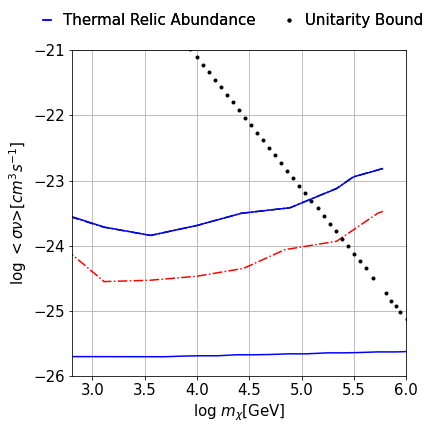

In [57]:
color = ['black', 'orange', 'purple']
color_sm = ['red', 'crimson', 'blue']
ll = ['-.', '--', '-.']
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True)  # std_size, std_size * 6. / 8.),
for j,i in enumerate(config["pone"]["specific particle scaling"].keys()):
    # Limits
    # ---------------------------------------------
    # Setup

    
    # ---------------------------------------------
    # Plotting
    #plt.title('P-ONE Limits Results',fontsize=fontsize)  # +' Scaling Correction = '+str(config['advanced']['scaling correction'])
    
    ax1.contour(pdm.results[i], levels = [0.9], colors=color[j],  linestyles=ll[j],
                origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                        min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    #ax1.contour(limits_com[i], levels = [0.9], colors=color_sm[j],  linestyles=ll[j],
    #            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    break    
ax1.contour(limits_ice["numu"], levels=[0.9], colors='blue',origin='lower',linestyles='-',
                            extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(limits_pone_unsm["numu"], levels=[0.9], colors='red',origin='lower',linestyles='-.',
                            extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
#ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature P-ONE')
#ax1.plot(np.log10(cl_lit_ice[:, 0]), np.log10(cl_lit_ice[:, 1]),label='literature  IceCube')
ax1.plot(np.log10(th_cl[:, 0]), np.log10(th_cl[:, 1]), 'b', 
         label='Thermal Relic Abundance')
ax1.plot(np.log10(unitarity[:, 0]), np.log10(unitarity[:, 1]), '.k', 
         label='Unitarity Bound')
# ---------------------------------------------
# Axis options
ax1.set_xscale("linear")
ax1.set_yscale("linear")
ax1.set_xlabel(r"$\log$ $m_{\chi}$[GeV]", fontsize=fontsize)
ax1.set_ylabel(r"$\log$ $<\sigma \nu$>[$cm^{3} s^{-1}$]", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize)
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize)
ax1.set_xlim(2.8, max(np.log10(mass_grid)))
ax1.set_ylim(min(np.log10(sv_grid)), -21)  # 
#ax1.text(3.5, -23.7, "IceCube Simulation", fontsize=fontsize)

#ax1.text(3.2, -24.8, r"P-ONE $\nu_\mu$", fontsize=fontsize)
#ax1.text(3.2, -24.9, r" $\nu_e$", fontsize=fontsize)
#ax1.text(3.1, -25.3, r" $\nu_\tau$", fontsize=fontsize)

# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(1.09, +1.09),
                 ncol=2, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.grid()
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "Limits_Example_all"+".png",
               bbox_inches='tight', dpi=export_dpi)


In [58]:
#pickle.dump(pdm.results, open('../data/_smea_limits.pkl', 'wb'))

KeyError: 'nue'

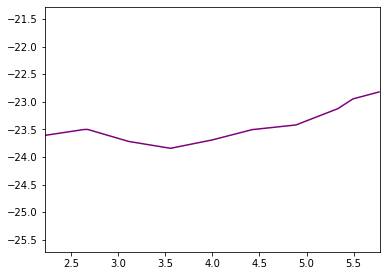

In [59]:
# All Limits-------------------------------------------
# Setup
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
ax1.contour(pdm.results["numu"], levels = [0.9], colors='purple', linestyles='-',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(pdm.results["nue"], levels = [0.9], colors='purple', linestyles='--',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)), 
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(pdm.results["nutau"], levels = [0.9], colors='purple', linestyles='-.',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
#ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature 90% C.L')
ax1.plot(np.log10(th_cl[:, 0]), np.log10(th_cl[:, 1]), 'b', 
         label='literature Thermal Relic Abundance')
ax1.contour(limits["numu"], levels=[0.9], colors='red',origin='lower',
                                extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                        min(np.log10(sv_grid)), max(np.log10(sv_grid))), legend='IceCube')
ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature 90% C.L P-ONE')
ax1.plot(np.log10(cl_lit_ice[:, 0]), np.log10(cl_lit_ice[:, 1]), label='literature 90% C.L IceCube')
# ---------------------------------------------
# Axis options
ax1.set_xscale("linear")
ax1.set_yscale("linear")
ax1.set_xlabel(r"log $m_{\chi}$", fontsize=fontsize)
ax1.set_ylabel(r"log <$\sigma\nu$>", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5, direction='in')
ax1.set_xlim(min(np.log10(mass_grid)), max(np.log10(mass_grid)))
ax1.set_ylim(min(np.log10(sv_grid)),-23.0)
# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------
ax1.text(3.5, -23.7, "IceCube", fontsize=fontsize)
ax1.text(3.4, -24.4, "P-ONE", fontsize=fontsize)
ax1.text(3.2, -24.3, r"$\nu_\mu$", fontsize=fontsize)
ax1.text(3.2, -24.9, r"$\nu_e$", fontsize=fontsize)
ax1.text(3.1, -25.3, r"$\nu_\tau$", fontsize=fontsize)
ax1.text(4.2, -25.5, "Thermal Relic Abundance", fontsize=fontsize)
plt.grid()
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "All_Limits.png",
               bbox_inches='tight', dpi=export_dpi)

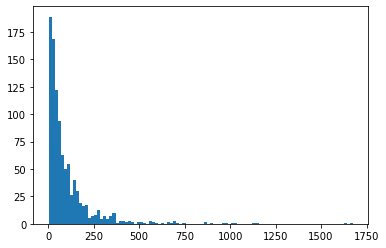

In [ ]:
samples = np.random.lognormal(4, 0.3 * 4., 1000)
count, bins, ignored = plt.hist(samples, 100, density=False, align='mid')

In [ ]:
mid_e_grid = np.logspace(3, 4, 100)

In [ ]:
spl_mid_mean = UnivariateSpline([1e3, 1e4], [700., 1e4], k=1)
spl_mid_sigma = UnivariateSpline([1e3, 1e4], [0.45, 0.35], k=1)

In [ ]:
def local_log_normal(x, mu, sigma):
    """Distribution function 
    x = E_grid
    mu = log(E) 
    sigma = fraction of E  ( so no fraction or percentage ) ( standard deviation as per definition )
    """
    sigma = ( sigma  )
    pdf = np.exp(-( np.log(x) - mu )**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))

    return pdf

In [ ]:
def distro_parms(Etrue):
    """ Parameter estimation function depending  on the E_true
    [mu] = [log(E/GeV)]
    sigma = fraction of E 
    """
    if Etrue < 1e3:
        mu = np.log(700)
        sigma = 0.45 
    elif 1e3 <= Etrue <= 1e4:
        mu = np.log(spl_mid_mean(Etrue))
        sigma = spl_mid_sigma(Etrue) 
    else:
        mu = np.log(Etrue)
        sigma = 0.35 
    return mu, sigma


#def smearing(Etrue, number_of_events, sampling_grid=hist_grid):
#    mu, sigma = distro_parms(Etrue)
#    return (
#        np.nan_to_num(local_log_normal(sampling_grid, mu, sigma)) *
#        number_of_events
#    )


In [ ]:
samples_fun = []
samples = []
for i,E in enumerate(pdm._shower_sim.egrid):
    mu, sigma = distro_parms(E)
    samples.append(np.random.lognormal((mu), sigma, len(e_grid))) # Axis0 = E, meaning the axis0 elements are the E_ture for which axis1 correspondece as distribution !!! Thats why transpose for imshow
    samples_fun.append(np.nan_to_num(local_log_normal(e_grid, mu, sigma)))

In [ ]:
samples[0]

array([1931.66788073,  442.52182814,  464.27331622,  681.11592916,
        475.21945766,  913.85083418,  860.83899991,  549.55393498,
        552.36624062,  384.66568459,  670.79926085, 1005.38027074,
        753.1606112 , 1063.4905859 ,  714.3984222 ,  698.54997411,
        224.47277459,  777.03107064, 1184.247377  ,  483.81733442,
        495.5694915 ,  282.98456772,  655.35673215, 1287.19123337,
        785.32167192, 1143.56591006,  548.94148549,  498.98730086,
        831.19480374,  207.72346752,  529.93028592,  550.8911818 ,
       1156.72348639,  431.42023652, 1070.08168982,  496.38630767,
        311.51842455,  493.06598126, 1254.83046286,  628.03873769,
        540.92909386,  449.58654974,  926.84721465,  892.24648986,
        876.78961017,  473.43194317,  429.75149998,  471.73843982,
        250.29132406,  295.88602571,  354.88039856,  817.26293895,
        556.31856743,  700.99282405,  705.4725524 ,  477.75666075,
        960.44139778,  627.34959365,  469.28909253,  870.55496

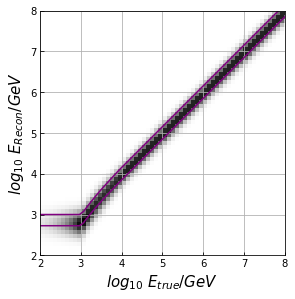

In [ ]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6./8. ), sharex=True)
z_p=ax1.imshow((np.array(samples_fun).T)*e_grid, origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid)) ), cmap=plt.get_cmap('binary'))
#figure.colorbar(z_p, ax=(ax1))
ax1.contour(np.array(samples_fun*e_grid).T, levels = [0.68], colors='purple', linestyles='-',
            origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid))) )
#ax1.contour((samples_fun*e_grid).T, levels = [1.2], colors='purple', linestyles='-',
#            origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid))) )


ax1.set_xlabel(r"$log_{10}$ $E_{true} / GeV$", fontsize=fontsize)
ax1.set_ylabel(r"$log_{10}$ $E_{Recon} / GeV$", fontsize=fontsize)
#ax1.set_ylabel(r"Distribution fraction", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5, direction='in')
ax1.set_xlim(2,8)
ax1.set_ylim(2,8)
# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)

plt.grid()

In [ ]:
for i,_ in enumerate(e_grid):
    print(np.trapz(samples_fun[i], x=e_grid))

1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.0088599515463972
1.0088599515463972
1.008859951546397
1.008859951546397
1.008859951546397
1.008859951546397
1.0088599515463965
1.0088599515463967
1.0088599515463967
1.008859951546397
1.008

NameError: name 'count_np' is not defined

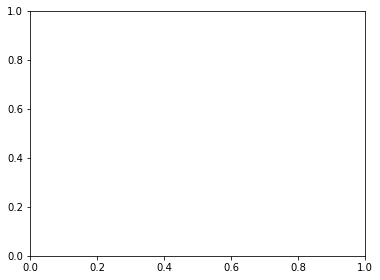

In [ ]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6./8. ), sharex=True)
ax1.imshow((count_np*e_grid).T, origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid)) ))
ax1.set_xlabel(r"log $E_{true}$", fontsize=fontsize)
ax1.set_ylabel(r"log $E_{Recon}$", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5, direction='in')

# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)

plt.grid()

In [ ]:
np.array(count_np).shape

In [ ]:
count_np